In [18]:
import tensorflow as tf
tf.python.control_flow_ops = tf

import os
import pandas as pd
import numpy as np
import cv2
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, \
MaxPooling2D, Conv2D, Lambda, Cropping2D, Convolution2D,\
AveragePooling2D
from keras.callbacks import History,TensorBoard, EarlyStopping, ModelCheckpoint
from sklearn.cross_validation import train_test_split

from copy import deepcopy


from sklearn.utils import shuffle

import tensorflow as tf
#tf.python.control_flow_ops = tf

epochs = 50
batch_size = 128
image_columns = 32
image_rows = 16
image_channels = 1
side_shift = 0.3



In [3]:
size=(40*4,80*4)

def preprocessing(im):
    return cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2YUV),(size[1],size[0]))

In [60]:
def mod_path(path, folder):
    return folder+'IMG/'+path.split('/')[-1]

def get_pd(folder):
    df=pd.read_csv(folder+'driving_log.csv', skiprows=1,\
            names=['center','left','right','steering','trottle','brake','speed'])
    
    df['center']=df.center.apply(lambda x:mod_path(x,folder))
    df['left']=df.left.apply(lambda x:mod_path(x,folder))
    df['right']=df.right.apply(lambda x:mod_path(x,folder))
    
    return df

In [61]:
datadirs=['/notebooks/udacity/new_training/map1_backward/',
                 '/notebooks/udacity/new_training/map1_forward/',
                 '/notebooks/udacity/new_training/map1_recovery_backward/',
                 '/notebooks/udacity/new_training/map1_recovery_forward/',
                 '/notebooks/udacity/new_training/map2_forward/',
                 '/notebooks/udacity/new_training/map2_backward/',
                 '/notebooks/udacity/new_training/map2_recovery_forward/',
                 '/notebooks/udacity/new_training/map2_recovery_backward/']

In [143]:
if not os.path.exists('images.pk1'):
    images=pd.concat([get_pd(a) for a in datadirs])

    train, test_and_valid=train_test_split(range(len(images)),test_size=0.2)
    test,valid=train_test_split(test_and_valid, test_size=0.5)

    s=np.empty(len(images), dtype=np.uint8)
    s[train]=0
    s[valid]=1
    s[test]=2

    images['dataset']=s
    images['inverse']=False

    images2=deepcopy(images)
    images2['inverse']=True
    
    images=pd.concat([images,images2])
    
    left=deepcopy(images)
    right=deepcopy(images)
    left['side']=1
    right['side']=-1
    left['img']=left.left
    right['img']=right.right
    images['img']=images.center
    images['side']=0
    
    images=pd.concat([images[['img','side','steering','dataset','inverse']],\
                      left[['img','side','steering','dataset','inverse']],\
                      right[['img','side','steering','dataset','inverse']]\
                     ])
    

    images.to_pickle('images.pk1')
else:
    images=pd.read_pickle('images.pk1')

In [144]:
import cv2
import numpy as np
import sklearn

size=(40,80)

def preprocessing(im):
    return cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2YUV),(size[1],size[0]))

def generator(df, dataset, correction=0.2, preprocessing=lambda x:x, batch_size=128, output_dim=(160,320,3)):
    
    samples=df[df.dataset==dataset].values
    num_samples = len(samples)
    
    print (num_samples)
    
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for i, batch_sample in enumerate(batch_samples):
                img,side,steering,dataset,inverse  = batch_sample
                image = cv2.imread(img)
                angle=steering+side*correction
                if inverse:
                    image=np.fliplr(image)
                    angle*=-1

                angles.append(angle)
                images.append(preprocessing(image))



            yield sklearn.utils.shuffle(np.array(images), np.array(angles))

# compile and train the model using the generator function
train_generator = generator(deepcopy(images), dataset=0, batch_size=128, preprocessing=preprocessing)
validation_generator = generator(deepcopy(images), dataset=1, batch_size=128, preprocessing=preprocessing)
test_generator = generator(deepcopy(images), dataset=2, batch_size=128, preprocessing=preprocessing)



In [71]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K



In [146]:
model=Sequential()

model.add(Cropping2D(cropping=((12,4), (0,0)), \
                     input_shape=(40,80,3)))

model.add(Lambda(lambda x: (x / 255.0) - 0.5))

model.add(AveragePooling2D(pool_size=(4,4)))

model.add(Convolution2D(32,3, 3,
                 activation='relu'))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1))

In [147]:
with open("model_lenet.json", "w") as json_file:
    json_file.write(model.to_json())

In [148]:
model.compile(loss='mse',\
              optimizer='adam', metrics=['mean_squared_error'])

In [149]:
checkpoint = ModelCheckpoint("model_tf.h5", monitor='val_mean_squared_error', verbose=1,
                              save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_mean_squared_error',\
                           min_delta=0.001, patience=2,
                            verbose=1, mode='min')

history = History()

tb=TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)



In [ ]:
model.fit_generator(train_generator, \
                    samples_per_epoch=len(images[images.dataset==0]),\
                    nb_epoch=100,\
                    verbose=1,\
                    validation_data=validation_generator, \
                    nb_val_samples=len(images[images.dataset==1]),\
                    callbacks=[checkpoint, early_stop,history,tb]\
                   )

Instructions for updating:
Please switch to tf.summary.merge_all.
Epoch 1/100
184926
184926/184926 [==============================] - 202s - loss: 0.0792 - mean_squared_error: 0.0792 - val_loss: 0.0950 - val_mean_squared_error: 0.0950
Epoch 2/100
184926/184926 [==============================] - 202s - loss: 0.0717 - mean_squared_error: 0.0717 - val_loss: 0.0917 - val_mean_squared_error: 0.0917
Epoch 3/100
184926/184926 [==============================] - 202s - loss: 0.0698 - mean_squared_error: 0.0698 - val_loss: 0.0865 - val_mean_squared_error: 0.0865
Epoch 4/100
184926/184926 [==============================] - 200s - loss: 0.0682 - mean_squared_error: 0.0682 - val_loss: 0.0876 - val_mean_squared_error: 0.0876
Epoch 5/100
184926/184926 [==============================] - 201s - loss: 0.0666 - mean_squared_error: 0.0666 - val_loss: 0.0881 - val_mean_squared_error: 0.0881
Epoch 6/100
184926/184926 [==============================] - 201s - loss: 0.0663 - mean_squared_error: 0.0663 - val_l

In [140]:
res=model.evaluate_generator(test_generator,val_samples=len(images[images.dataset==1]))

23118


In [141]:
res

[0.22894133070893266, 0.22894132989806404]

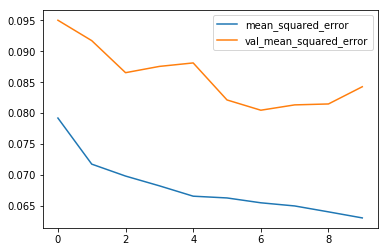

0.0804718037189 6


In [151]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(history.history['mean_squared_error'], label='mean_squared_error')
plt.plot(history.history['val_mean_squared_error'], label='val_mean_squared_error')

plt.legend()
plt.show()

print (min(history.history['val_mean_squared_error']), np.argmin(history.history['val_mean_squared_error']))

In [19]:
history.history

{'loss': [0.09260721446480602,
  0.079403439071029425,
  0.072888279624748975,
  0.075551021378487349,
  0.07251321425428614,
  0.069755333475768566,
  0.073090171499643475,
  0.072361166530754417,
  0.07209851173684001,
  0.070820422713146647,
  0.067636933352332562,
  0.070532249344978482],
 'mean_squared_error': [0.092607213999144733,
  0.079403439129237086,
  0.072888279217295349,
  0.075551021785940975,
  0.072513214836362749,
  0.069755333883222193,
  0.07309017120860517,
  0.0723611667053774,
  0.072098511445801705,
  0.07082042259763377,
  0.067636933177709579,
  0.07053224858827889],
 'val_loss': [0.078616713692787416,
  0.077824946791907809,
  0.07774363234918992,
  0.074454033312810475,
  0.072818793984468666,
  0.072191015567844546,
  0.07395735911901645,
  0.070014840731129624,
  0.066888193484970423,
  0.067809660312076955,
  0.067149044551232009,
  0.069905247342886653],
 'val_mean_squared_error': [0.078616713858609202,
  0.07782494702405833,
  0.077743632017546332,
  0.